In [7]:
import dlib
import cv2
import imutils
from imutils.face_utils import FaceAligner
import os
import numpy as np
import pandas as pd
import keras
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array

from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

import scipy.io
from datetime import datetime, timedelta

In [8]:
target_size = (224, 224)
# yuz tespiti yapan detektor
face_detector = dlib.get_frontal_face_detector()

# fotografta yuz var mi kontrolu
def check_detection(img):
    exact_image = False
    if type(img).__module__ == np.__name__:
        exact_image = True

    base64_img = False
    if len(img) > 11 and img[0:11] == "data:image/":
        base64_img = True


    elif not exact_image:  # image path passed as input

        if not os.path.isfile(img):
            raise ValueError("Confirm that ", img, " exists")

        img = cv2.imread(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects, scores, idx = face_detector.run(gray,1,-1)
            
    if len(rects) > 0:
        return True
    else:
        return False
    
# yuz tespit eden fonksyion
def detect_face(img):
    exact_image = False
    if type(img).__module__ == np.__name__:
        exact_image = True

    base64_img = False
    if len(img) > 11 and img[0:11] == "data:image/":
        base64_img = True

    elif not exact_image:
        if not os.path.isfile(img):
            raise ValueError("Confirm that ", img, " exists")

        img = cv2.imread(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # rects: yuz tespiti yapilan cerceve
    # scores: yuz tespiti skorlari
    # best_score_index: en yuksek skora sahip yuzun indisi
    rects, scores, idx = face_detector.run(gray,1,-1)
    best_score_index = np.argmax(scores)
    faces = []
    # tespit edilen yuzler fotograftan kirpiliyor 
    for rect in rects:
        detected_face = img[max(0, rect.top()): min(rect.bottom(), img.shape[0]),
                    max(0, rect.left()): min(rect.right(), img.shape[1])]
        
        # fotograflar 224, 224 hale getiriliyor
        detected_face = cv2.resize(detected_face, (target_size[0], target_size[1]))
        faces.append(detected_face)

    return faces[best_score_index]

In [9]:
# veri setinde yasi hesaplayan fonksiyon
def datenum_to_datetime(datenum):
    days = datenum % 1

    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    exact_date = datetime.fromordinal(int(datenum)) \
                 + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
                 + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) \
                 - timedelta(days=366)

    return exact_date.year

In [10]:
# veriyi uygun formata getiren fonksiyon
def get_pixels(img_path):
    new_img_path = "wiki_crop/" + img_path[0]

    img = load_img(new_img_path, grayscale=False, target_size=(224, 224))
    img_pixels = img_to_array(img)
    img_pixels = np.expand_dims(img_pixels, axis=0)
    img_pixels /= 255
    return img_pixels

In [11]:
# verinin okunmasi
mat = scipy.io.loadmat('wiki_crop/wiki.mat')
instances = mat['wiki'][0][0][0].shape[1]

columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]
df = pd.DataFrame(index=range(0, instances), columns=columns)

for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
for j in range(len(current_array)):
    df[columns[j]] = pd.DataFrame(current_array[j][0])

df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)
df['age'] = df['photo_taken'] - df['date_of_birth']
# yuzu olmayan fotograflar cikartiliyor
df = df[df['face_score'] != -np.inf]

# birden fazla yuz barindiran fotograflar cikartiliyor
df = df[df['second_face_score'].isna()]

# yuz skoru threshold altinda kalanlar cikartiliyor
df = df[df['face_score'] >= 3]

# cinsiyeti olmayan fotograflar cikartiliyor
df = df[~df['gender'].isna()]

df = df.drop(
    columns=['name', 'face_score', 'second_face_score', 'date_of_birth', 'face_location', 'dob', 'photo_taken'])
# 0 - 100 yas araliginda olmayanlar cikartiliyor
df = df[df['age'] <= 100]
df = df[df['age'] > 0]

In [6]:
df.head()

,full_path,gender,age
0,[17/10000217_1981-05-05_2009.jpg],1.0,28
2,[12/100012_1948-07-03_2008.jpg],1.0,60
4,[16/10002116_1971-05-31_2012.jpg],0.0,41
5,[02/10002702_1960-11-09_2012.jpg],0.0,52
6,[41/10003541_1937-09-27_1971.jpg],1.0,34


In [7]:
# pathlerin uygun formata getirilmesi
paths = []
for index, i in enumerate(df['full_path']):
    paths.append(i[0])
df['path'] = paths
df['path'] = "wiki_crop/" + df['path']
df = df.drop(columns=['full_path', 'age'])

In [9]:
df.head()

,gender,path
0,1.0,wiki_crop/17/10000217_1981-05-05_2009.jpg
2,1.0,wiki_crop/12/100012_1948-07-03_2008.jpg
4,0.0,wiki_crop/16/10002116_1971-05-31_2012.jpg
5,0.0,wiki_crop/02/10002702_1960-11-09_2012.jpg
6,1.0,wiki_crop/41/10003541_1937-09-27_1971.jpg


In [11]:
# yuz tespit edilemeyen fotograflarin cikartilmasi
df['detection'] = df['path'].apply(check_detection)
df = df[df.detection == True]
df = df.drop(columns='detection')

In [14]:
# verinin training icin uygun hale getirilmesi
classes = 2
target = df['gender'].values
target_classes = keras.utils.to_categorical(target, classes)

features = []

for i in range(0, df.shape[0]):
    features.append(df['path'].values[i])

In [15]:
train_x, test_x, train_y, test_y = train_test_split(features, target_classes, test_size=0.20)

In [16]:
# veri setinde yuz tespiti yapiliyor
temp_list = []
for i in train_x:
    img = detect_face(i)
    temp_list.append(img)

train_x = temp_list
temp_list2 = []
    
for i in test_x:
    img = detect_face(i)
    temp_list2.append(img)

test_x = temp_list2

In [17]:
# veriler egitim icin uygun formata getiriliyor (memory tuketimi fazla olabilir)
train_x = np.array(train_x)/255
test_x = np.array(test_x)/255

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y
                                        , test_size=0.1, random_state=17)

In [18]:
# vgg-face modeli
model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(224, 224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

model.load_weights('vgg_face_weights.h5')

for layer in model.layers[:-7]:
    layer.trainable = False
    
# son katmanlar eklenerek egitim icin hazir hale getiriliyor
base_model_output = Sequential()
base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

beauty_model = Model(inputs=model.input, outputs=base_model_output)

beauty_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  , metrics=['accuracy']
                 )

In [19]:
# /models klasoru olmasi gereklidir. Her tur sonunda en iyi model kontrolu yapilarak kaydedilecektir. 
checkpointer = ModelCheckpoint(
    filepath='models/gender.hdf5'
    , monitor="val_loss"
    , verbose=1
    , save_best_only=True
    , mode='auto'
)

# patience early stopping icin gerekli,
# val_loss'un azalmasinin kac epoch beklenecegini belirtir. Azalmazsa egitimi durdurur.
patience = 5
epochs = 10

early_stop = EarlyStopping(monitor='val_loss', patience=patience)

score = beauty_model.fit(
        train_x, train_y
        , epochs=epochs
        , validation_data=(val_x, val_y)
        , callbacks=[checkpointer, early_stop]
    )

Epoch 1/10
498/498 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9474
Epoch 00001: val_loss improved from inf to 0.10526, saving model to models/gender_new.hdf5
498/498 [==============================] - 219s 439ms/step - loss: 0.1634 - accuracy: 0.9474 - val_loss: 0.1053 - val_accuracy: 0.9610
Epoch 2/10
498/498 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9665
Epoch 00002: val_loss did not improve from 0.10526
498/498 [==============================] - 214s 429ms/step - loss: 0.1075 - accuracy: 0.9665 - val_loss: 0.1267 - val_accuracy: 0.9644
Epoch 3/10
498/498 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 0.9739
Epoch 00003: val_loss improved from 0.10526 to 0.09210, saving model to models/gender_new.hdf5
498/498 [==============================] - 221s 445ms/step - loss: 0.0873 - accuracy: 0.9739 - val_loss: 0.0921 - val_accuracy: 0.9718
Epoch 4/10
498/498 [==============================] - ETA: 0s - loss: 

In [24]:
# en iyi model tekrar yuleniyor
from keras.models import load_model
beauty_model = load_model("models/gender.hdf5")

In [25]:
results = beauty_model.evaluate(test_x, test_y, verbose=1)
print(f'results:{results}')

139/139 [==============================] - 36s 255ms/step - loss: 0.0883 - accuracy: 0.9668
results:[0.08834103494882584, 0.9667796492576599]


Confusion Matrix

[[3117   32]
 [ 115 1161]]
       Woman   Man
Woman   3117    32
Man      115  1161


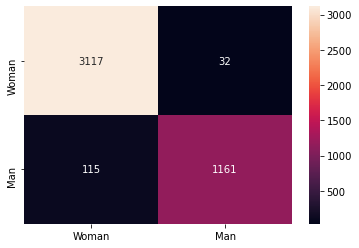

In [28]:
predictions = beauty_model.predict(test_x)
prediction_classes = []
actual_classes = []
beauty_classes = ['Woman', 'Man']
for i in range(0, predictions.shape[0]):
    prediction = np.argmax(predictions[i])
    prediction_classes.append(beauty_classes[prediction])
    actual = np.argmax(test_y[i])
    actual_classes.append(beauty_classes[actual])

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

cm = confusion_matrix(actual_classes, prediction_classes)
print(cm)
df_cm = pd.DataFrame(cm, index=beauty_classes, columns=beauty_classes)
print(df_cm)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt=".0f")